In [ ]:
# !pip install ale-py==0.7.4
!pip install sb3_contrib
!pip install stable_baselines3
# !pip install stable_baselines3[extra]

     |████████████████████████████████| 62 kB 599 kB/s 
     |████████████████████████████████| 177 kB 19.2 MB/s 
     |████████████████████████████████| 1.5 MB 43.7 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=bca0cea49f64e04d073f1df54afb0f01372874cf511ce0b46f64eacd47b4c5cf
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
import gym
from sb3_contrib import QRDQN
# from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from time import perf_counter
from matplotlib import pyplot as plt

In [ ]:
# env = make_atari_env('Breakout-v0')
env = gym.make('CartPole-v1')

In [ ]:
# ATARI
# hyperparams = {
#   "exploration_fraction": 0.025,  # explore 250k steps = 10M * 0.025
#   "optimize_memory_usage": True
# }
# CARTPOLE
hyperparams = {
"learning_rate": 0.0023,
"batch_size": 64,
"buffer_size": 100000,
"learning_starts": 1000,
"target_update_interval": 10,
"train_freq": 256,
"gradient_steps": 128,
"exploration_fraction": 0.16,
"exploration_final_eps": 0.04
}

In [ ]:
quantiles_domain = range(1, 20, 2)
iterations = 20

In [ ]:
means = []
stds = []
times = []

# MlpPolicy for CartPole; CnnPolicy for Atari
for q in quantiles_domain:
    print(f"\n\nn_quantiles={q}\n-----")
    inner_means = []
    inner_stds = []
    inner_time = float('inf')
    for i in range(iterations):
        print(f"iteration #{i}/{iterations}")
        model = QRDQN('MlpPolicy', env, verbose=0, **hyperparams, policy_kwargs=dict(n_quantiles=q))

        start_perf = perf_counter()
        model.learn(total_timesteps=2000)  # how many for CartPole?
        end_perf = perf_counter()

        val, std = evaluate_policy(model, Monitor(env), n_eval_episodes=200)  # 200 for CartPole

        inner_means.append(val)
        inner_stds.append(std)
        inner_time = min(inner_time, end_perf - start_perf)
    means.append(sum(inner_means) / len(inner_means))
    stds.append(sum(inner_stds) / len(inner_stds))
    times.append(inner_time)

mean reward: 116.37; std: 28.276723643307758
training time: 2.131239468999979
mean reward: 118.445; std: 59.61197006474455
training time: 2.0296491809999964
mean reward: 93.745; std: 46.085355320318406
training time: 2.0209208160000003
mean reward: 9.685; std: 0.9411562038259113
training time: 1.9954816309999899
mean reward: 24.965; std: 3.7991808327585566
training time: 1.9516644849999807
mean reward: 23.635; std: 4.90731851421935
training time: 1.9923908670000117
mean reward: 30.47; std: 3.8586396566665826
training time: 2.0180329570000026
mean reward: 37.265; std: 8.57290936613703
training time: 1.9802291509999748
mean reward: 296.16; std: 210.07004641309527
training time: 2.0129003929999953
mean reward: 53.92; std: 36.24601495337108
training time: 1.9776557290000198
mean reward: 91.175; std: 28.397259991062516
training time: 1.9629593820000082
mean reward: 21.02; std: 4.740210965769351
training time: 1.9793326660000048
mean reward: 33.315; std: 6.55787884914017
training time: 2.009

<ErrorbarContainer object of 3 artists>

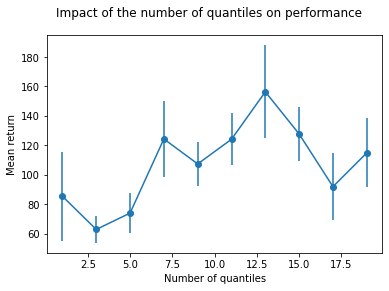

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Impact of the number of quantiles on performance")
ax.set_xlabel("Number of quantiles")
ax.set_ylabel("Mean return")
ax.errorbar(quantiles_domain, means, yerr=stds, fmt='-o')